# Dimensionality reduction

In this first tutorial we are going to explore some clustering algorithms on the `iris` dataset, which contains 5 features (sepal length, sepal width, petal length, petal width, and species). To do that, we will use the popular `sklearn` Python library. Let's start by loading the data in our environment. `sklearn` is shipped with the `iris` dataset, so we can easily just call the related function. In addition, we use the `polars` library to handle our data as a `dataframe` for fast queries.


In [7]:
from sklearn.datasets import load_iris
import polars as pl

# load iris dataset
iris = load_iris(as_frame=True)

# assign target values to actual target species names
iris.frame["target"] = iris.target_names[iris.target]

# build polars dataframe
iris = pl.DataFrame(iris.frame)

# show first 10 rows
iris.head(10)


sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""setosa"""
4.9,3.0,1.4,0.2,"""setosa"""
4.7,3.2,1.3,0.2,"""setosa"""
4.6,3.1,1.5,0.2,"""setosa"""
5.0,3.6,1.4,0.2,"""setosa"""
5.4,3.9,1.7,0.4,"""setosa"""
4.6,3.4,1.4,0.3,"""setosa"""
5.0,3.4,1.5,0.2,"""setosa"""
4.4,2.9,1.4,0.2,"""setosa"""


We can now extract some features of interest and explore a bit more what the data looks like. For instance, let's say we are interested in getting the mean value of each feature per species. Let's say we are also interested in knowing the max value of sepal length and the minimum value of sepal width. To achieve this, we can use the powerful `polars` queries.

In [30]:
# mean per species
mean_by_spp = iris.group_by("target").mean()
print(mean_by_spp)

# multiple queries per single group_by operation
summaries = iris.group_by("target").agg([
    pl.col("sepal length (cm)").max().alias("max sepal length (cm)"),
    pl.col('sepal width (cm)').min().alias('max sepal width (cm)')])
print(summaries)

shape: (3, 5)
┌────────────┬───────────────────┬──────────────────┬───────────────────┬──────────────────┐
│ target     ┆ sepal length (cm) ┆ sepal width (cm) ┆ petal length (cm) ┆ petal width (cm) │
│ ---        ┆ ---               ┆ ---              ┆ ---               ┆ ---              │
│ str        ┆ f64               ┆ f64              ┆ f64               ┆ f64              │
╞════════════╪═══════════════════╪══════════════════╪═══════════════════╪══════════════════╡
│ setosa     ┆ 5.006             ┆ 3.428            ┆ 1.462             ┆ 0.246            │
│ virginica  ┆ 6.588             ┆ 2.974            ┆ 5.552             ┆ 2.026            │
│ versicolor ┆ 5.936             ┆ 2.77             ┆ 4.26              ┆ 1.326            │
└────────────┴───────────────────┴──────────────────┴───────────────────┴──────────────────┘
shape: (3, 3)
┌────────────┬───────────────────────┬──────────────────────┐
│ target     ┆ max sepal length (cm) ┆ max sepal width (cm) │
│ ---      

For more advanced computations on large dataframes, it is recommended to use the `polars` lazy API, which is natively multithreaded and optimized in the background for faster operations. For example, we can calculate the approximate area of each petal, pretending they look like triangles. Note that our current dataframe consists only of 150 observations, so there is no real benefit of using the lazy API.

In [31]:
lazy_area = iris.lazy().with_columns(
    (pl.col("petal length (cm)") * pl.col("petal width (cm)") / 2).alias("petal area (cm2)")
)

# ecplore the computation tree in the background
print(lazy_area.explain(optimized=True))

 WITH_COLUMNS:
 [[([(col("petal length (cm)")) * (col("petal width (cm)"))]) / (2.0)].alias("petal area (cm2)")] 
  DF ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]; PROJECT */5 COLUMNS


Because the computation is lazy, we can collect the results whenever we need them. We can also chain more computations and collect the result at the very end.

In [32]:
# add additional computation: get sum of petal areas
lazy_area = lazy_area.group_by("target").agg(pl.sum("petal area (cm2)")).collect()
lazy_area

target,petal area (cm2)
str,f64
"""versicolor""",143.01
"""virginica""",282.405
"""setosa""",9.14


Now that we have explored a bit our data, it seems easier to visualize the relationships among variables. Earlier we saw one way to do this: plot each variable again the other. However, this may not work when our data consists of many features (high dimensional space). One way to deal with this is by reducing the dimensionality of the data. The most common and easy approach to do dimensionality reduction is via a **Principal Component Analysis**. `sklearn` provides an intuitive API to achive this.

We will reduce the 4 dimensions of our data down to 3, so that we can better explore the relationship among variables in a 3D space. In addition, we can retrieve the names of the features that went in the PCA, so that we can use there 3 features, for example, as uncorrelated model variables.

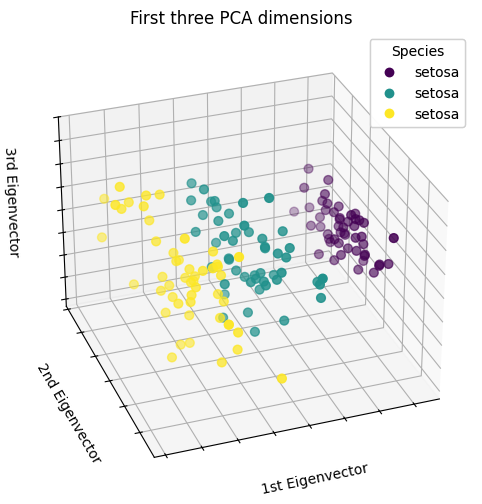


Explained variance by component (%): [92.46187232  5.30664831  1.71026098]

Feature names matching components: petal length (cm), sepal length (cm), petal width (cm)


In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# initialize PCA object
pca = PCA(n_components=3)

# run PCA on all column but "target"
spp = iris["target"]
iris = iris.drop("target")
iris_reduced = pca.fit_transform(iris)

# prepare for plotting: assign an integer to each character target value
spp = spp.to_frame().with_columns(
    colors=pl.col("target").replace_strict(["setosa", "versicolor", "virginica"], [1, 2, 3])
)

# plot the result (make a function to use later)
def plot_me(data, **kwargs):
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
    scatter = ax.scatter(
        data[:, 0],
        data[:, 1],
        data[:, 2],
        c=kwargs.get("colors"),
        s=40,
    )
    ax.set(
        title="First three PCA dimensions",
        xlabel="1st Eigenvector",
        ylabel="2nd Eigenvector",
        zlabel="3rd Eigenvector",
    )
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    # add legend
    legend1 = ax.legend(
        scatter.legend_elements()[0],
        kwargs.get("legend"),
        loc="upper right",
        title=kwargs.get("legend_title"),
    )
    ax.add_artist(legend1)

    plt.show()

plot_args = {
    "colors": spp["colors"],
    "legend": spp["target"],
    "legend_title": "Species"
}
plot_me(iris_reduced, **plot_args)

# explained variance
print(f"\nExplained variance by component (%): {pca.explained_variance_ratio_ * 100}\n")

# get components
coords = pca.components_

# get largest 3 values for first component, explaining ~92% of the variance
ind = coords[0].argsort()[-3:][::-1]

# corresponding colum names
print(f"Feature names matching components: {', '.join([iris.columns[i] for i in ind])}")

# Clustering

Great! So far we explored some data dimensionality reduction routines. It is time to dive deeper into other unsupervised learning tools. With clustering techniques, we try to understand unseen relationship within the data. This process sometimes can be persived as more "subjective" than supervised approached, simply because the relationships between input and output values have not been stated. Therefore, the final result we will obtain is a function of the algorithm we will use in our data exploration quest.

In general, when dealing with different units of measurement or highly dimensional data, it is good practice to scale your data prior to cluster it. For example, consider that your dataset is composed of a variety of units and ranges (e.g. areas, volumes, counts, costs, etc.). In this scenario, scaling your data beforehand is almost necessary because clustering algorithms work by measuring similarities or distances. Therefore, one feature may dominate the other simply because it may have a larger interquartile range.

One of the most basic and simple clustering algorithms you will encounter is **K-Means**. K-Means is a data partitioning algorithm that finds the best boundaries in a high dimensional data space such that the centroids of data "clusters" are the farthest apart from each other (i.e. the most disinguishable). Let's try it!

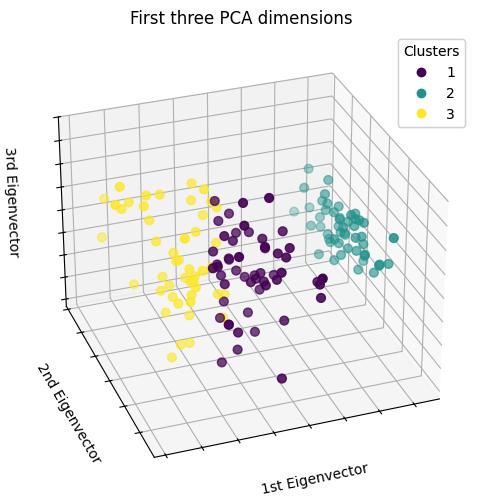

In [98]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# initialize kmeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# initialize processing pipeline: first scale then kmeans
pipeline = make_pipeline(StandardScaler(), kmeans)

# get cluster labels (iris here has only 4 features)
labels = pipeline.fit_predict(iris)

# plot the result
plot_args = {
    "colors": labels,
    "legend": ["1", "2", "3"],
    "legend_title": "Clusters"
}
plot_me(iris_reduced, **plot_args)

You may see that the clusters that we identified via KMeans are pretty well-structured, however there is some confusion when compared to the actual data. In this case we don't need to adjust the number of clusters, nor identify the best number because we already know about the output labels. Let's now work with a different dataset where we have no prior knowledge of how the data shoule be categoried.

### Raster data
Raster data is represented by a flat grid where each cell or pixel is generally represented as a square. Multiband raster data is a stack of flat grids where each grid represents a property of interest, like in the image below. The horizontal axis represents the X coordinate (longitude), while the vertical axis represents the Y (latitude). Raster data introduce an additional level of complexity, that is spatial information that is associated to each observation (pixel).

![RasterStack](../img/cube.png)

Let's then try to classify a multiband raster using a different approach than before. We know introducte a new family of clustering algorithms that partition the data by iteratively agglomerating observations. In this scenario, we don't have to set a number of clusters a priori, we first build our hierarchical agglomerative structure and later we decide where to cut the tree. You'll understand this in a moment.

Our first pick is a traditional **Hierarchial Clustering (HC)** technique. We start by identifiying relationships among observations based on distances, which will be used to build a linkage tree that dictates how observations are related to each other. Pretty much like a lineage tree. Once again, we can use the easy `sklearn` syntax to achive this.